# Advanced Lane Finding


**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

I am heavily inspired by it. :)

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

In the function calibrate():  
By defining chessboard corner counts in two dimensions, object points and image points (actually the corners from the cv2.findChessboardCorners()), and by using these parameters in cv2.calibrateCamera, the camera calibration parameters are extracted.

In the function undistort():  
Simply using cv2.undistort with the parameters which are found above, I undistort the images.

In [4]:
def calibrate():
    chessboard_list = os.listdir("./camera_cal")
    nx = 9
    ny = 6

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for chessboard in chessboard_list:

        img = cv2.imread("./camera_cal/" + chessboard)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    calibration_parameters = {}
    calibration_parameters["mtx"] = mtx
    calibration_parameters["dist"] = dist
    pickle.dump(calibration_parameters, open("calibration.p", "wb"))
    return mtx, dist

In [5]:
mtx, dist = calibrate()

In [6]:
def undistort(image, mtx, dist):
    undist = cv2.undistort(image, mtx,
                            dist, None,
                            mtx)
    return undist

And here is an example for the distortion corrected chessboard image:

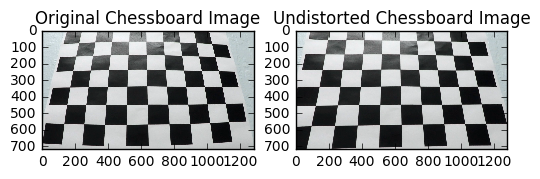

In [7]:
image = cv2.imread("./camera_cal/calibration3.jpg")
undistorted_image = undistort(image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image)
ax1.set_title('Original Chessboard Image')
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Chessboard Image')

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used the combination of sobel thresholding on x axis, s channel thresholding, and blue channel thresholding. Also magniture and direction thresholding is tried, but it made the algorithm slower without too much contribution.

The helper functions which are implemented are below:

In [8]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(sobelx**2 +  sobely**2)
    scaled = np.uint8(255*magnitude/np.max(magnitude))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def color_thresh(image, thresh=(0, 255)):
    color_binary = np.zeros_like(image)
    color_binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return color_binary

And here is the example for the thresholding operation on single image pipeline:

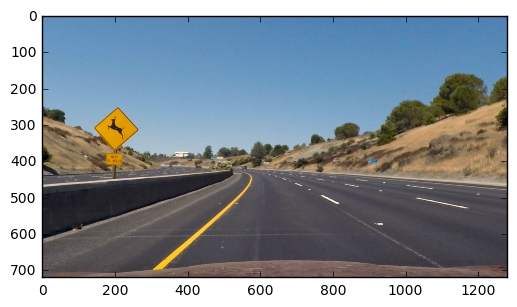

In [9]:
image = cv2.imread('./test_images/test2.jpg')
undist = undistort(image, mtx, dist)
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))

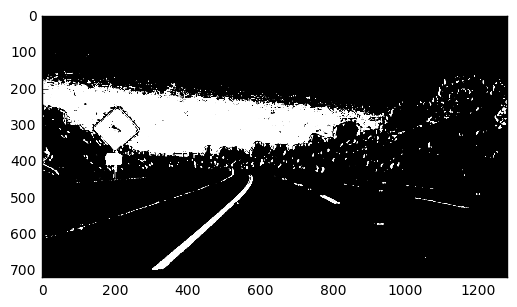

In [10]:
hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

s = undistort(hls_image[:,:,2], mtx, dist)
b = undistort(image[:,:,0], mtx, dist)
gray = undistort(gray, mtx, dist)

s_binary = color_thresh(s, (160, 255))
b_binary = color_thresh(b, (200, 255))

color_combined = np.zeros_like(s_binary)

x_binary = abs_sobel_thresh(gray, 'x', 15, (70, 180))
color_combined[(s_binary == 1) | (x_binary == 1) | (b_binary == 1)] = 1

plt.imshow(color_combined, cmap='gray')
# plt.imshow(s_binary, cmap='gray')

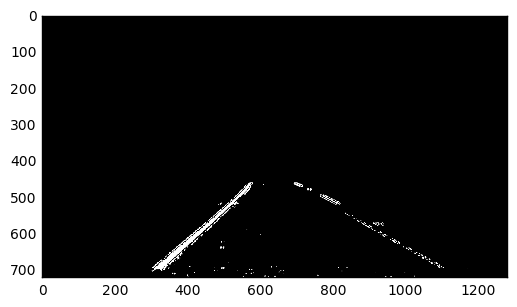

In [11]:
hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s = undistort(hls_image[:,:,2], mtx, dist)
r = undistort(image[:,:,0], mtx, dist)

s_binary = color_thresh(s, (190, 255))
r_binary = color_thresh(r, (20, 255))
    

x_binary = abs_sobel_thresh(r, 'x', 13, (20, 100))
    
    #combined_all = np.zeros_like(sr_combined)
combined_all = np.zeros_like(s_binary)
    
    #combined_all[(sr_combined == 1) | (x_binary == 1)] = 1
combined_all[(s_binary == 1) | (x_binary == 1)] = 1
    
vertices = np.array([[(570, 460), (200, 720), (1240, 720), (740, 460)]])
mask = np.zeros_like(combined_all)
cv2.fillPoly(mask, vertices, 255)
color_combined = cv2.bitwise_and(combined_all, mask)
plt.imshow(color_combined, cmap='gray')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The perspective transform is implemented in the code block below, perpective_transform(). Inverse transform is stored for unwarping image afterwards

In [12]:
def perspective_transform(image, source_points, destination_points):
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    warped = cv2.warpPerspective(image, M, (1280, 720), flags=cv2.INTER_LINEAR)

    return warped, Minv

The source points are chosen by inspection (by finding a trapezoid with side lines parallel to the straight lane lines roughly).

And here is an example for the perspective transform:

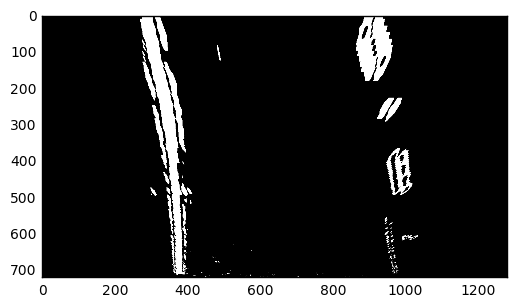

In [13]:
source_points = np.float32([[579, 460], [210, 720], [1128, 720], [706, 460]])
destination_points = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

warped, Minv = perspective_transform(color_combined, source_points, destination_points)
plt.imshow(warped, cmap='gray')

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Firstly, the approximate lane line positions (basis positions) are found by finding the histogram peaks:

Left peak is on:  369
Right peak is on:  959


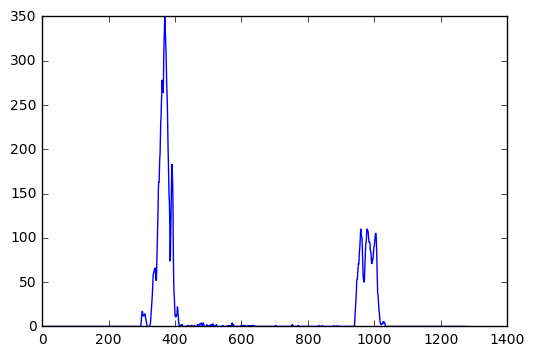

In [14]:
hist = np.sum(warped[warped.shape[0]//2:, :], axis=0)
plt.plot(hist)

left_peak = np.argmax(hist[:warped.shape[1]//2])
right_peak = np.argmax(hist[warped.shape[1]//2:]) + warped.shape[1]//2

print("Left peak is on: ", left_peak)
print("Right peak is on: ", right_peak)

After that, the polynomial points are defined with the sliding windows search which is performed on the image:

In [16]:
out_img = np.dstack((warped, warped, warped))*255


nwindows = 9
window_height = warped.shape[0] // nwindows

nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = left_peak
rightx_current = right_peak

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []


# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

By using np.polyfit function, polynomial fits are generated for the lines:

In [17]:
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

To extrapolate the polynomials along the road, and generating the x and y values for plotting, the polynomial fit results are used:

(720, 0)

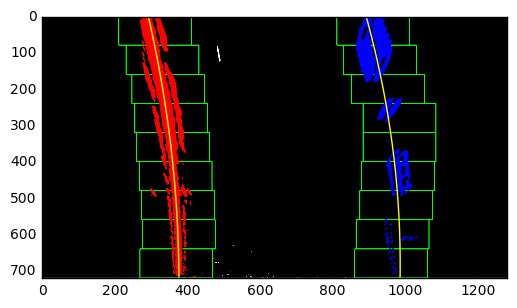

In [18]:

# Generate x and y values for plotting
fity = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

This time, the polynomial fit is performed with the real world values by approximating length by pixel values.

It is close to 1 km in this image, as expected.

In [19]:
ym_per_pix = 30 / 720
xm_per_pix = 3.7 / 700
y_eval = np.max(fity)*ym_per_pix
    
left_fit_real = np.polyfit(fity*ym_per_pix, fit_leftx*xm_per_pix, 2)
right_fit_real = np.polyfit(fity*ym_per_pix, fit_rightx*xm_per_pix, 2)

# Find the curve radii
left_roc = ((1 + (2*left_fit_real[0]*y_eval*ym_per_pix + left_fit_real[1])**2)**1.5) \
                             /np.absolute(2*left_fit_real[0])

right_roc = ((1 + (2*right_fit_real[0]*y_eval*ym_per_pix + right_fit_real[1])**2)**1.5) \
                             /np.absolute(2*right_fit_real[0])

radius_of_curvature = (left_roc + right_roc) / 2
print("The radius of curvature is: ", radius_of_curvature)

The radius of curvature is:  933.09963193


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

Below is the shape drawn by using cv2.fillPoly with the generated x and y values above.

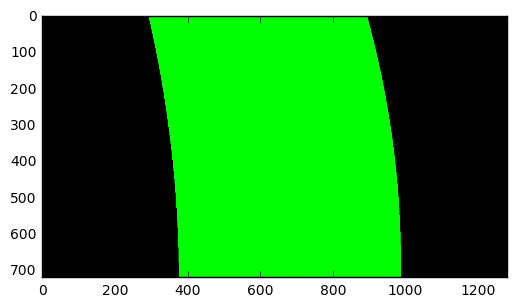

In [20]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)

color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

plt.imshow(color_warp)

By using the inverse perspective transform matrix which is found earlier, the image found above is unwarped. And it is superposed on the original image (undistorted version of it).

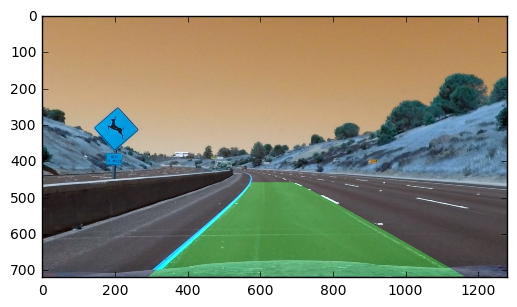

In [21]:
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720)) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

All the code which is presented above is refactored and tidied up. Also, object oriented approach is used for convenience. For smoothing and keeping track of the values over the video, Line class is implemented.

Moreover, to increase performance in terms of speed, optimized search is implemented to use after lines are found.

Now, the code blocks will be explained.

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
def calibrate():
    chessboard_list = os.listdir("./camera_cal")
    nx = 9
    ny = 6

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for chessboard in chessboard_list:

        img = cv2.imread("./camera_cal/" + chessboard)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    calibration_parameters = {}
    calibration_parameters["mtx"] = mtx
    calibration_parameters["dist"] = dist
    pickle.dump(calibration_parameters, open("calibration.p", "wb"))
    return mtx, dist

In [40]:
def undistort(image, mtx, dist):
    undist = cv2.undistort(image, mtx,
                            dist, None,
                            mtx)
    return undist

In [41]:
def perspective_transform(image, source_points, destination_points):
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    warped = cv2.warpPerspective(image, M, (1280, 720), flags=cv2.INTER_LINEAR)

    return warped, Minv

In [42]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(sobelx**2 +  sobely**2)
    scaled = np.uint8(255*magnitude/np.max(magnitude))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def color_thresh(image, thresh=(0, 255)):
    color_binary = np.zeros_like(image)
    color_binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return color_binary

The container class "Parameters" for convenience:

In [43]:
# Container class for geometrical parameters
class Parameters:
    def __init__(self):
        # Calibration parameters
        self.mtx = None
        self.dst = None
        # Perspective transform parameters
        self.M = None
        self.Minv = None
        self.warped_shape = None
        # Masking parameter
        self.vertices = None
        self.mask = None

The "Line" class has the parameters for buffering and smoothing operations.

Also, it has three functions "update_fit", "update_peak", "update_metrics" to update and store there values in lists.

In [44]:
class Line():
    def __init__(self):
        # Maximum of the buffer
        self.limit = 30
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None 
        #polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        #polynomial coefficients for the most recent metric fit
        self.current_metric_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = []
        self.best_roc = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Current peak of histogram
        self.peak = None
        # Recent peaks of histogram
        self.recent_peaks = []
        # Average of the peaks
        self.best_peak = None
        # Lane indices
        self.line_inds = []
        # Current lane indices
        self.current_line_inds = None
        
    def update_fit(self, values, metric_values, xfit):
        self.recent_fits.append(values)
        self.current_fit = values
        self.recent_xfitted.append(xfit)
        if len(self.recent_fits) > self.limit:
            self.recent_fits = self.recent_fits[1:]
            self.recent_xfitted = self.recent_xfitted[1:]
        self.best_fit = np.mean(self.recent_fits, axis=0)
        self.current_metric_fit = metric_values
        self.bestx = np.mean(self.recent_xfitted, axis=0)
    
    def update_peak(self, value):
        self.peak = value
        self.recent_peaks.append(value)
        if len(self.recent_peaks) > self.limit:
            self.recent_peaks = self.recent_peaks[1:]
        self.best_peak = np.mean(self.recent_peaks, axis=0)
        
    def update_metrics(self, curverad):
        self.radius_of_curvature.append(curverad)
        if len(self.radius_of_curvature) > self.limit:
            self.radius_of_curvature = self.radius_of_curvature[1:]
            
        self.best_roc = np.mean(self.radius_of_curvature, axis=0)

In [45]:
left_line = Line()
right_line = Line()

In [46]:
parameters = Parameters()
parameters.mtx, parameters.dst = calibrate()
parameters.image_size = (1280, 720)

The image procesing (undistorting, filtering, masking and warping) operations which are mentioned in the single image pipeline, are implemented here for the video:

In [47]:
def process_image2(image):
    # image = cv2.GaussianBlur(image, (5, 5), 0)
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    #
    s = undistort(hls_image[:,:,2], parameters.mtx, parameters.dst)
    b = undistort(image[:,:,2], parameters.mtx, parameters.dst)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = undistort(gray, parameters.mtx, parameters.dst)
    s_binary = color_thresh(s, (160, 255))
    b_binary = color_thresh(b, (200, 255))
    color_combined = np.zeros_like(s_binary)
    x_binary = abs_sobel_thresh(gray, 'x', 15, (70, 180))
    color_combined[(s_binary == 1) | (x_binary == 1) | (b_binary == 1)] = 1
    #
    #combined_all = np.zeros_like(sr_combined)
    combined_all = np.zeros_like(s_binary)
    
    #combined_all[(sr_combined == 1) | (x_binary == 1)] = 1
    combined_all[(s_binary == 1) | (x_binary == 1)] = 1
    
    vertices = np.array([[(570, 460), (200, 720), (1240, 720), (740, 460)]])
    mask = np.zeros_like(combined_all)
    cv2.fillPoly(mask, vertices, 255)
    combined_all = cv2.bitwise_and(combined_all, mask)


    source_points = np.float32([[582, 460], [210, 720], [1128, 720], [704, 460]])
    destination_points = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

    warped, parameters.Minv = perspective_transform(combined_all, source_points, destination_points)
    
    return warped

This function finds the basis peak values and updates the peak list of the line objects:

In [48]:
def set_base_peak(warped):
    hist = np.sum(warped[720//2:, :], axis=0)
    
    left_line.update_peak(np.argmax(hist[:1280//2]))
    right_line.update_peak(np.argmax(hist[1280//2:]) + 1280//2)

In [49]:
def search_in_frame(warped, nonzerox, nonzeroy):
    nwindows = 9
    window_height = warped.shape[0] // nwindows

    leftx_current = left_line.peak
    rightx_current = right_line.peak

    margin = 70
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_line_inds = np.concatenate(left_lane_inds)
    right_line_inds = np.concatenate(right_lane_inds)
    return left_line_inds, right_line_inds

This function performs an optimized search once the lines are found:

In [50]:
def search_in_margin(image, nonzerox, nonzeroy):
    margin = 70
    left_line_inds = ((nonzerox > (left_line.best_fit[0]*(nonzeroy**2) 
                                   + left_line.best_fit[1]*nonzeroy 
                                   + left_line.best_fit[2] - margin)) 
                      & (nonzerox < (left_line.best_fit[0]*(nonzeroy**2) 
                                     + left_line.best_fit[1]*nonzeroy 
                                     + left_line.best_fit[2] + margin))).nonzero()[0]
    right_line_inds = ((nonzerox > (right_line.best_fit[0]*(nonzeroy**2) 
                                    + right_line.best_fit[1]*nonzeroy 
                                    + right_line.best_fit[2] - margin)) 
                       & (nonzerox < (right_line.best_fit[0]*(nonzeroy**2) 
                                      + right_line.best_fit[1]*nonzeroy 
                                      + right_line.best_fit[2] + margin))).nonzero()[0]

    return left_line_inds, right_line_inds

This function calculates polynomial fits and the radius of curvature for each line.

In [51]:
def calculate_metrics(line):
    ploty = np.linspace(0, 719, 720)
    fit = np.polyfit(line.ally, line.allx, 2)
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    # Fit second order polynomial with real world values
    ym_per_pix = 30 / 720
    xm_per_pix = 3.7 / 700
    y_eval = np.max(line.ally)*ym_per_pix
    
    fit_real = np.polyfit(line.ally*ym_per_pix, line.allx*xm_per_pix, 2)
    
    
    # Update fits of the lines
    line.update_fit(fit, fit_real, fitx)
    fit = line.best_fit
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    # Find the curve radii
    radius_of_curvature = ((1 + (2*fit_real[0]*y_eval*ym_per_pix + fit_real[1])**2)**1.5) \
                             /np.absolute(2*fit_real[0])
    line.update_metrics(radius_of_curvature)

And this function visualizes the unwarped version of the image with the radius of curvature and lane position values:

In [55]:
def visualize(image, warped):
    ploty = np.linspace(0, 719, 720)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    undist = undistort(image, parameters.mtx, parameters.dst)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, parameters.Minv, (1280, 720)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Display values
    #curverad = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2
    curverad = (left_line.best_roc + right_line.best_roc) / 2
    lane_offset = (left_line.line_base_pos + right_line.line_base_pos) / 2
    result = cv2.putText(result, "Curvature radius: " + str(curverad), (200, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4)
    result = cv2.putText(result, "Lane position: " + str(lane_offset), (200, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4)
    return result

And this is the implementation for the video frame processing:

In [56]:
def pipeline(image):
    check = False
    # Undistorting, filtering and perspective transform
    warped = process_image2(image)

    # For visualization
    out_img = np.dstack((warped, warped, warped))*255
    
    # Identifying nonzero x and y pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Finding basis histogram peaks
    set_base_peak(warped)
    
    left_line_inds = []
    right_line_inds = []
    
    # Sliding windows search, in frame or in small margin
    if (left_line.detected and right_line.detected):
        left_line_inds, right_line_inds = search_in_margin(image, nonzerox, nonzeroy)
    else:
        left_line_inds, right_line_inds = search_in_frame(image, nonzerox, nonzeroy)
        
    left_line.detected = False
    right_line.detected = False
    
    if len(left_line_inds) > 0 and len(right_line_inds) > 0:
        
        left_line.allx = nonzerox[left_line_inds]
        right_line.allx = nonzerox[right_line_inds]
        left_line.ally = nonzeroy[left_line_inds]
        right_line.ally = nonzeroy[right_line_inds]
        
        if len(left_line.ally) > 0  and len(left_line.allx) > 0:
            left_line.detected = True
            calculate_metrics(left_line)
        if len(right_line.ally) > 0  and len(right_line.allx) > 0:
            right_line.detected = True
            calculate_metrics(right_line)
        check = True
    left_line.line_base_pos = (1280 / 2 - left_line.best_peak) * 3.7 / 700
    right_line.line_base_pos = (1280 / 2 - right_line.best_peak) * 3.7 / 700
    
    result = visualize(image, warped)
    
    return result

In [57]:
video_output = "output1.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|█████████▉| 1260/1261 [05:34<00:00,  3.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

CPU times: user 40min 55s, sys: 13.2 s, total: 41min 8s
Wall time: 5min 35s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Deciding over the different kinds of thresholding approaches was not easy, intuitive approaches were good for single images, but were sometimes failing on the video.

The pipeline will likely fail when there are large amounts of paint spilled on the road, near the lines.

To make it more robust, a different kind of threshold can be implemented. Also, machine learning approaches can be used for deciding over different kinds of filters on different conditions.

This was a nice project with much fun, but I understand better the importance of behavioral cloning approach now. :)